In [30]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import itertools
from sklearn.svm import LinearSVC
import scipy.io
import random
from sklearn.model_selection import KFold
import os
import sys
import reshape
from statistics import mean
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/FigsFinal/'
def multiclassAll():
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------
    train_sub : str
            Subject name for training
    test_sub : str
            Subject name for testing

    Returns
    -------------
    total_score : float
            Average accuracy of all folds

    """
    #clf=LinearSVC()
    all_CM_DS=np.zeros((5,5))
    all_CM_CV=np.zeros((5,5))
    fig=plt.figure(figsize=(25,20))#, constrained_layout=True)
    fig.text(.08, 1.05, 'a',fontsize=28)
    fig.text(.45, 1.05, 'Same Person',fontsize=28)
    fig.text(.08, .48, 'b',fontsize=28)
    fig.text(.43, .48, 'Different Person',fontsize=28)
    #plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 3 columns
    #gs = gridspec.GridSpec(nrows=4, ncols=4)
    gs00 = fig.add_gridspec(nrows=2, ncols=4,top=1, bottom=.55,wspace=0.1, hspace=0.13)
    gs01 = fig.add_gridspec(nrows=2, ncols=4, top=.45, bottom=0,wspace=0.1, hspace=0.13)
    b=0
    #clf=LogisticRegression(solver = 'lbfgs')
    #clf=LinearSVC()
    clf=RidgeClassifier()
    #train sub
    master_df=pd.DataFrame()
    d=pd.DataFrame()
    data=np.array(['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10'],dtype='<U61')
    loo = LeaveOneOut()
    for  test, train in loo.split(data): #train on one sub test on the rest
        CV_tmp=pd.DataFrame()
        DS_tmp=pd.DataFrame()
        train_sub=data[train]
        test_sub=data[test]
    #train sub
        memFC=reshape.matFiles(dataDir+'mem/'+train_sub[0]+'_parcel_corrmat.mat')
        semFC=reshape.matFiles(dataDir+'semantic/'+train_sub[0]+'_parcel_corrmat.mat')
        glassFC=reshape.matFiles(dataDir+'glass/'+train_sub[0]+'_parcel_corrmat.mat')
        motFC=reshape.matFiles(dataDir+'motor/'+train_sub[0]+'_parcel_corrmat.mat')
        restFC=reshape.matFiles(dataDir+'rest/'+train_sub[0]+'_parcel_corrmat.mat') #keep tasks seperated in order to collect the right amount of days
        #nsize=restFC.shape[1]
        #restFC=np.reshape(restFC,(10,4,nsize)) #reshape to gather correct days
        #test sub
        testFC,ytest=AllSubFiles(test_sub)
        same_Tsub, diff_Tsub,sameF,diffF,sameMCC, diffMCC, same_sub_CM, DS_cm=K_folds_MC(train_sub, clf, memFC,semFC,glassFC,motFC, restFC, testFC, ytest)
        DS=DS_cm / DS_cm.astype(np.float).sum(axis=1)
        CV=same_sub_CM / same_sub_CM.astype(np.float).sum(axis=1)
        if b<4:
            a=0
            ax1=fig.add_subplot(gs00[a,b])
            ax=ConfusionMatrixDisplay(CV,display_labels=["Rest","Memory","Semantic","Motor", "Coherence"]).plot(cmap=plt.cm.Blues,colorbar=False,ax=ax1)
            ax1.set_xlabel(' ')
            plt.title(train_sub[0],fontsize=25)

            ax2=fig.add_subplot(gs01[a,b])
            ax=ConfusionMatrixDisplay(DS,display_labels=["Rest","Memory","Semantic","Motor", "Coherence"]).plot(cmap=plt.cm.Blues,colorbar=False,ax=ax2)
            ax2.set_xlabel(' ')
            plt.title(train_sub[0],fontsize=25)
            if b==0:
                ax1.set_ylabel('True Label',fontsize=25)
                ax2.set_ylabel('True Label',fontsize=25)
                ax1.tick_params(labelsize=25)
                ax2.tick_params(labelsize=25)
                plt.setp(ax1.get_xticklabels(), visible=False)
                plt.setp(ax2.get_xticklabels(), visible=False)
            else:
                ax1.set_ylabel(' ')
                ax2.set_ylabel(' ')
                plt.setp(ax1.get_xticklabels(), visible=False)
                plt.setp(ax2.get_xticklabels(), visible=False)
                plt.setp(ax1.get_yticklabels(), visible=False)
                plt.setp(ax2.get_yticklabels(), visible=False)
            b=b+1
        else:
            a=1
            c=b-4
            ax1=fig.add_subplot(gs00[a,c])
            ax=ConfusionMatrixDisplay(CV,display_labels=["Rest","Memory","Semantic","Motor", "Coherence"]).plot(cmap=plt.cm.Blues,colorbar=False,ax=ax1)
            ax1.set_xlabel(' ')
            plt.title(train_sub[0],fontsize=25)

            ax2=fig.add_subplot(gs01[a,c])
            ax=ConfusionMatrixDisplay(DS,display_labels=["Rest","Memory","Semantic","Motor", "Coherence"]).plot(cmap=plt.cm.Blues,colorbar=False,ax=ax2)
            plt.xlabel('Predicted Label',fontsize=25)
            plt.title(train_sub[0],fontsize=25)
            if c==0:
                ax1.set_ylabel('True Label',fontsize=25)
                ax2.set_ylabel('True Label',fontsize=25)
                plt.xticks(rotation=90)
                ax1.tick_params(labelsize=25)
                ax2.tick_params(labelsize=25)
                plt.setp(ax1.get_xticklabels(), visible=False)
                #plt.setp(ax2.get_xticklabels(), visible=False)
            else:
                ax1.set_ylabel('')
                ax2.set_ylabel('')
                plt.setp(ax1.get_xticklabels(), visible=False)
                #plt.setp(ax2.get_xticklabels(), visible=False)
                plt.setp(ax1.get_yticklabels(), visible=False)
                plt.setp(ax2.get_yticklabels(), visible=False)
                ax2.tick_params(labelsize=25)
                plt.xticks(rotation=90)
            b=b+1

    plt.savefig(outDir+'MC_allSubs.png', bbox_inches='tight')

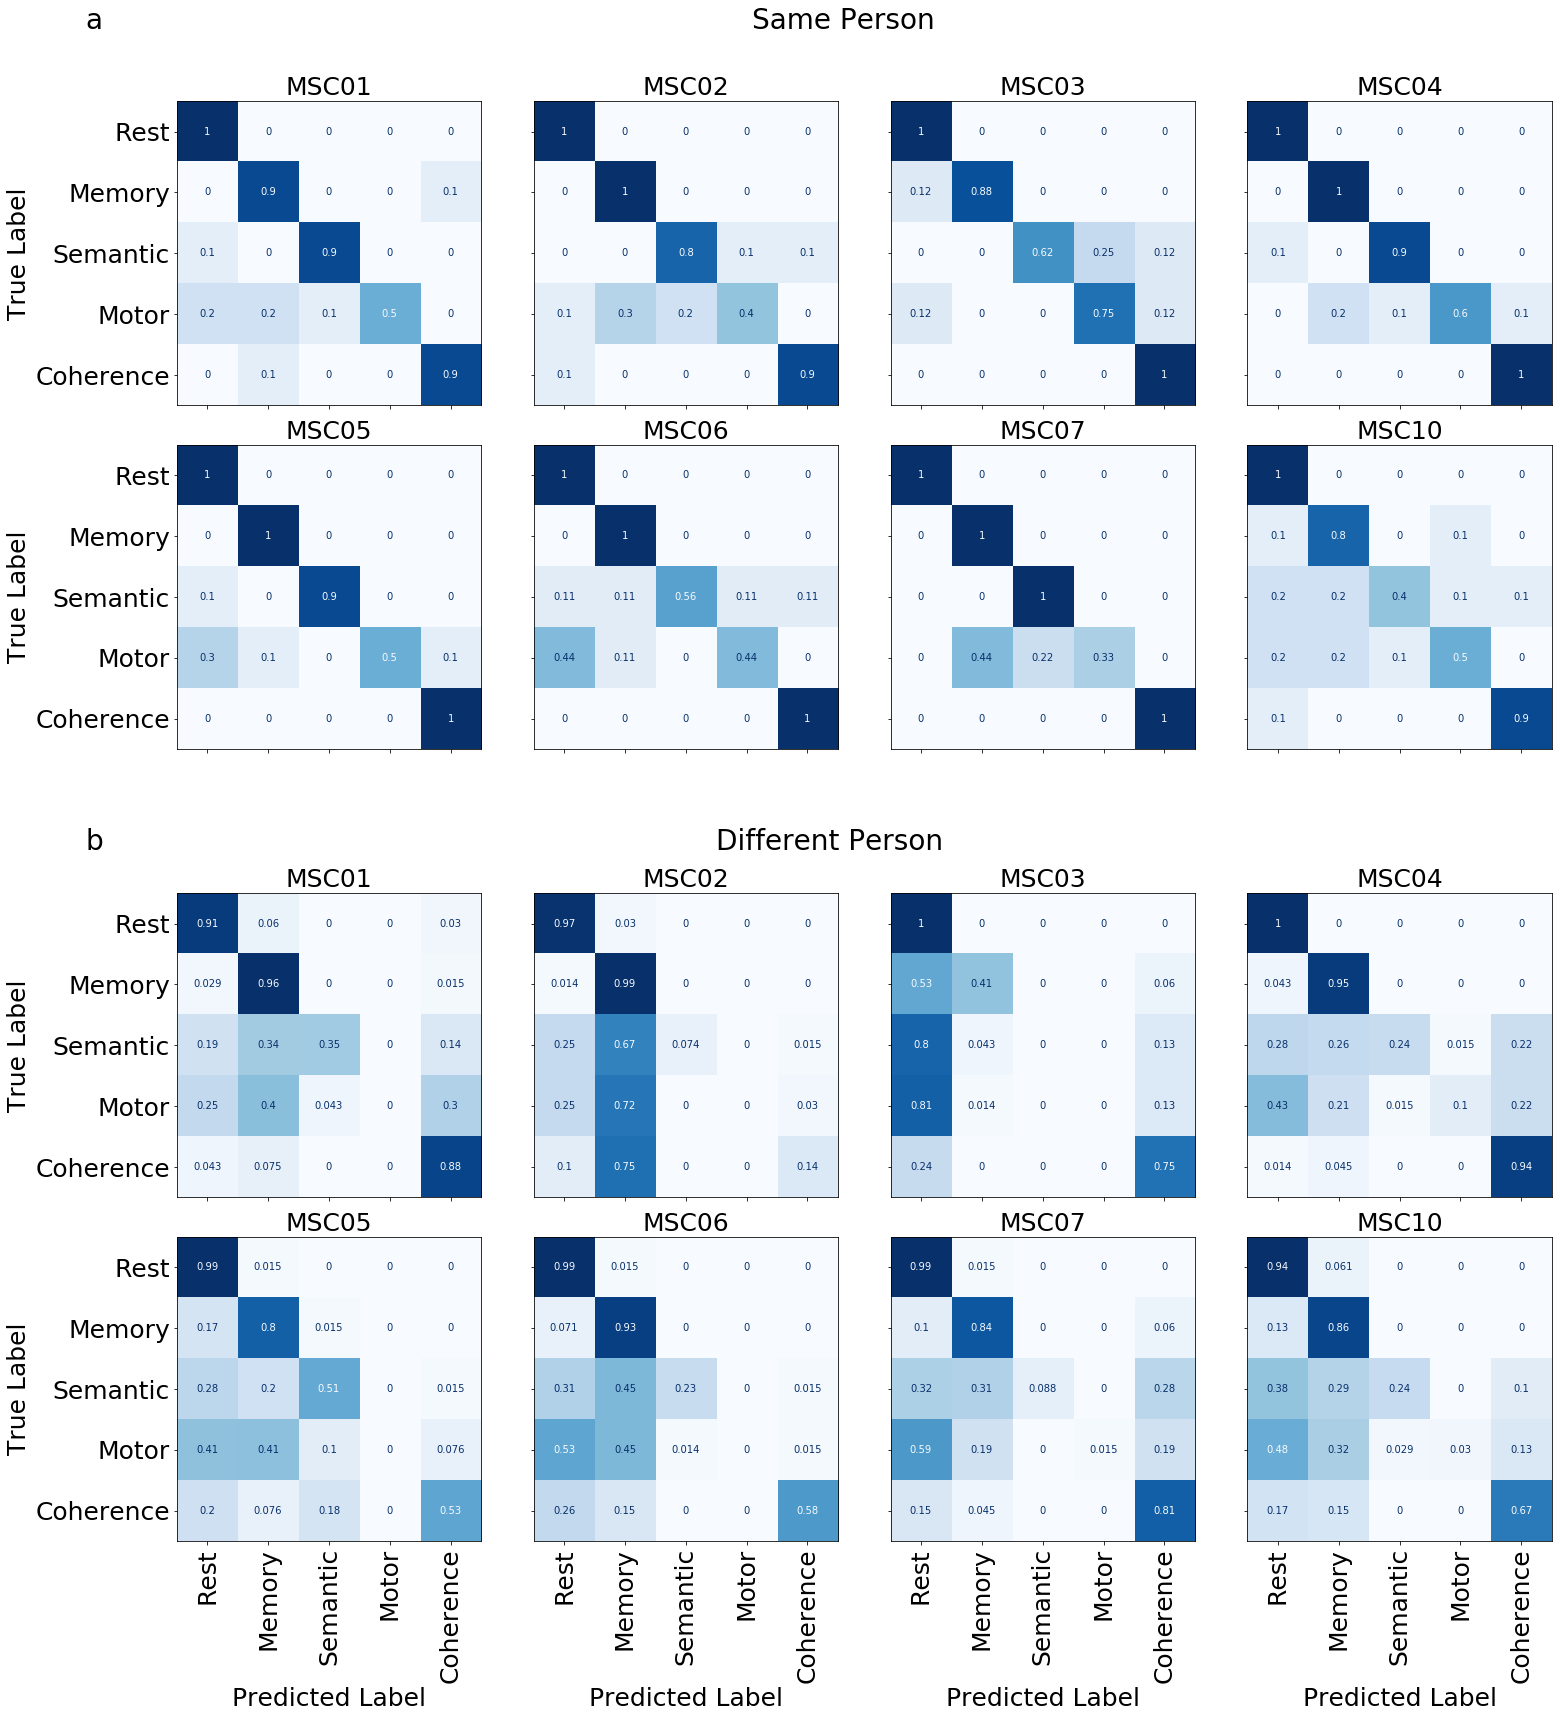

In [31]:
multiclassAll()